# Introduction

Based on eight variables, namely, the temperature of the wellhead, pressure of the wellhead, million standard cubic feet per day of gas, barrel of oil produced per day, the barrel of water produced per day, basic solid and water, the molecular mass of CO2, gas gravity, we compare six machine learning models (ML) to predict corrosion defects in oil and gas pipelines. The six ML models are random forest, support vector machine, k-nearest neighbor, gradient boosting, logistic regression, and decision tree. We use threshold corrosion defects to classify the state of the pipelines. Among the six models, the supportive vector machine model had the best accuracy with 95.5%, followed by the random forest classifier and K-neighbors with 90.4% and 84.1%, respectively; here we used as criteria the F1-score. In addition, we applied a reduced method analysis.

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
from IPython.display import Image

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from math import sqrt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.columns

Index(['Wellhead Temp. (C)', 'Wellhead Press (psi)', 'MMCFD- gas',
       'BOPD (barrel of oil produced per day)',
       'BWPD (barrel of water produced per day)',
       'BSW - basic solid and water (%)', 'CO2 mol. (%) @ 25 C & 1 Atm.',
       'Gas Grav.', 'CR-corrosion defect'],
      dtype='object')

# Data preprocessing

##  Check for missing values for all columns.

In [3]:
df.isnull().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of        Wellhead Temp. (C)  Wellhead Press (psi)  MMCFD- gas  \
0                   False                 False       False   
1                   False                 False       False   
2                   False                 False       False   
3                   False                 False       False   
4                   False                 False       False   
...                   ...                   ...         ...   
10287               False                 False       False   
10288               False                 False       False   
10289               False                 False       False   
10290               False                 False       False   
10291               False                 False       False   

       BOPD (barrel of oil produced per day)  \
0                                      False   
1                                      False   
2                                    

## Data description

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10292 entries, 0 to 10291
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Wellhead Temp. (C)                       10292 non-null  float64
 1   Wellhead Press (psi)                     10292 non-null  float64
 2   MMCFD- gas                               10292 non-null  float64
 3   BOPD (barrel of oil produced per day)    10292 non-null  float64
 4   BWPD (barrel of water produced per day)  10292 non-null  float64
 5   BSW - basic solid and water (%)          10292 non-null  float64
 6   CO2 mol. (%) @ 25 C & 1 Atm.             10292 non-null  float64
 7   Gas Grav.                                10292 non-null  float64
 8   CR-corrosion defect                      10292 non-null  float64
dtypes: float64(9)
memory usage: 723.8 KB


In [5]:
df.describe()

Wellhead Temp. (C)  Wellhead Press (psi)    MMCFD- gas  \
count        10292.000000          10292.000000  10292.000000   
mean            57.352401           1361.783583      8.851533   
std              9.423529            559.275420      4.968737   
min             41.070000            382.080000      0.230000   
25%             49.220000            880.000000      4.570000   
50%             57.360000           1364.900000      8.880000   
75%             65.412500           1848.252500     13.090000   
max             73.870000           2317.230000     17.540000   

       BOPD (barrel of oil produced per day)  \
count                           10292.000000   
mean                             1103.563396   
std                               565.392744   
min                               129.470000   
25%                               611.645000   
50%                              1106.085000   
75%                              1589.710000   
max                              2087.430000   

       BWPD (barrel of water produced per day)  \
count                             10292.000000   
mean                               4636.556014   
std                                2685.799834   
min                                  40.610000   
25%                                2295.520000   
50%                                4591.995000   
75%                                6997.442500   
max                                9314.260000   

       BSW - basic solid and water (%)  CO2 mol. (%) @ 25 C & 1 Atm.  \
count                     10292.000000                  10292.000000   
mean                         44.876740                      2.502574   
std                          25.710558                      1.041002   
min                           0.130000                      0.678600   
25%                          22.887500                      1.608650   
50%                          45.075000                      2.518100   
75%                          67.212500                      3.406125   
max                          89.260000                      4.298200   

          Gas Grav.  CR-corrosion defect  
count  10292.000000         10292.000000  
mean       0.821436             0.211285  
std        0.063142             0.037283  
min        0.711100             0.000900  
25%        0.766800             0.192100  
50%        0.821600             0.213500  
75%        0.876300             0.232800  
max        0.931900             0.405200

# Exploratory plotting

## Plots statiscal values for MMCFD- gas and wellhead temperature

<AxesSubplot:>

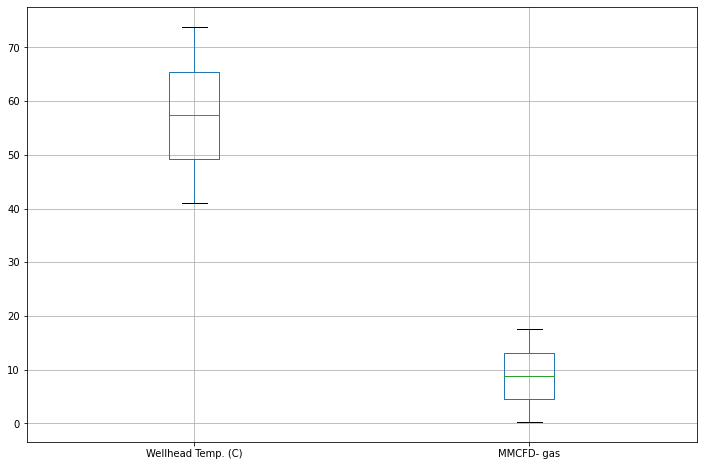

In [6]:
size = (12,8)
features = ['Wellhead Temp. (C)', 'MMCFD- gas']
df[features].boxplot(figsize=size)

## Histogram of corrosion defect

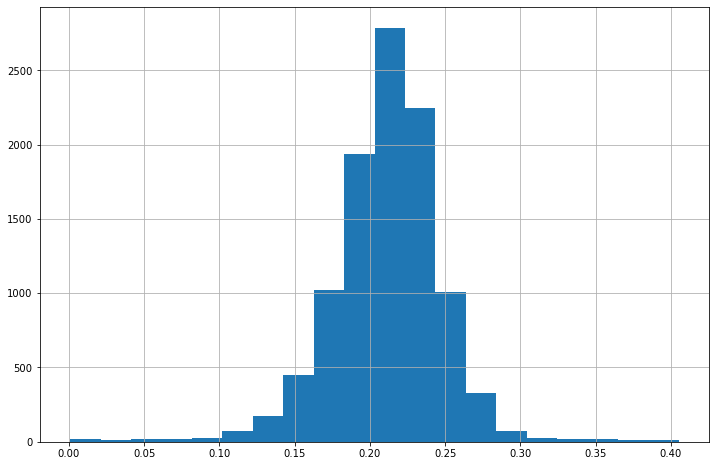

In [7]:
df['CR-corrosion defect'].hist(bins=20, figsize=(12,8) )
plt.show()

## Binarize corrosion defects 

In [4]:
df['binary'] = (df['CR-corrosion defect'] < 0.211).astype(int)

In [9]:
df

Wellhead Temp. (C)  Wellhead Press (psi)  MMCFD- gas  \
0                   53.35               1105.13       12.87   
1                   72.25               1026.31        3.42   
2                   65.08                722.96        6.23   
3                   60.71               1557.23       11.71   
4                   46.19               1304.42        8.58   
...                   ...                   ...         ...   
10287               56.81               2242.44        1.71   
10288               47.46               2243.44        2.42   
10289               54.03               2286.86        1.50   
10290               45.69               1674.08        3.42   
10291               63.31               2123.06        3.02   

       BOPD (barrel of oil produced per day)  \
0                                    1378.93   
1                                    1028.75   
2                                    2017.92   
3                                     558.22   
4                                    1280.47   
...                                      ...   
10287                                1470.60   
10288                                 727.07   
10289                                 967.96   
10290                                1312.84   
10291                                1312.97   

       BWPD (barrel of water produced per day)  \
0                                      2812.62   
1                                       919.92   
2                                      1212.42   
3                                      1716.09   
4                                      1929.22   
...                                        ...   
10287                                  5929.47   
10288                                  4184.95   
10289                                  4900.59   
10290                                  3476.96   
10291                                  7691.87   

       BSW - basic solid and water (%)  CO2 mol. (%) @ 25 C & 1 Atm.  \
0                                75.64                        3.3628   
1                                44.21                        3.8679   
2                                17.55                        2.3552   
3                                65.79                        1.7253   
4                                37.45                        1.8327   
...                                ...                           ...   
10287                            14.83                        2.0084   
10288                            37.04                        2.5155   
10289                             7.84                        3.7564   
10290                            23.08                        3.8039   
10291                            65.61                        3.1973   

       Gas Grav.  CR-corrosion defect  binary  
0         0.7205               0.2245       0  
1         0.8940               0.2262       0  
2         0.7661               0.2305       0  
3         0.7738               0.2303       0  
4         0.7611               0.2202       0  
...          ...                  ...     ...  
10287     0.7927               0.0031       1  
10288     0.7695               0.0027       1  
10289     0.8991               0.0027       1  
10290     0.7940               0.0022       1  
10291     0.7565               0.0009       1  

[10292 rows x 10 columns]

## Plot corrosion population

/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Cases')

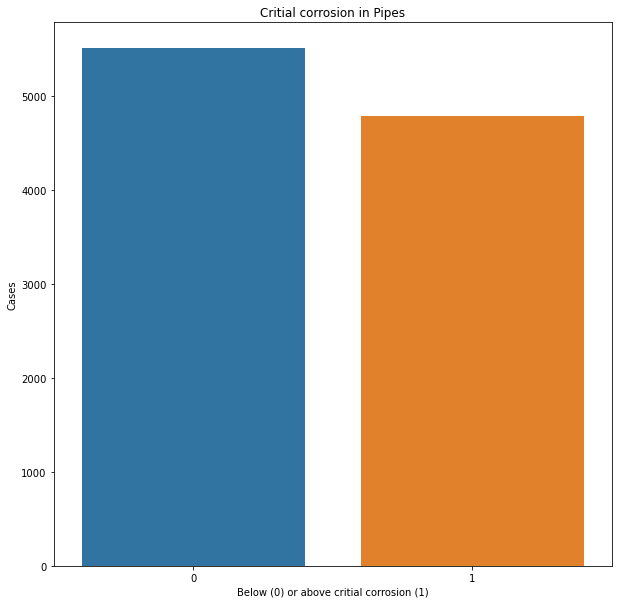

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(df['binary'])
plt.title('Critial corrosion in Pipes')
plt.xlabel('Below (0) or above critial corrosion (1)')
plt.ylabel('Cases')

# Extract features (X) and corresponding label data (y).

In [7]:
# X_inp = df.drop('CR-corrosion defect', axis='columns')
# y = df['CR-corrosion defect']

# Define low and high level of corrotion and split the df1 = df[df['CR-corrosion defect']<0.211]
X = df.iloc[:,0:8].values
y = df.iloc[:,9].values  # use binary conversion of corrosion
# y = df.binary.values

# Normalization to features
#X = MinMaxScaler().fit_transform(X)

In [8]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [9]:
X

array([[5.33500e+01, 1.10513e+03, 1.28700e+01, ..., 7.56400e+01,
        3.36280e+00, 7.20500e-01],
       [7.22500e+01, 1.02631e+03, 3.42000e+00, ..., 4.42100e+01,
        3.86790e+00, 8.94000e-01],
       [6.50800e+01, 7.22960e+02, 6.23000e+00, ..., 1.75500e+01,
        2.35520e+00, 7.66100e-01],
       ...,
       [5.40300e+01, 2.28686e+03, 1.50000e+00, ..., 7.84000e+00,
        3.75640e+00, 8.99100e-01],
       [4.56900e+01, 1.67408e+03, 3.42000e+00, ..., 2.30800e+01,
        3.80390e+00, 7.94000e-01],
       [6.33100e+01, 2.12306e+03, 3.02000e+00, ..., 6.56100e+01,
        3.19730e+00, 7.56500e-01]])

#  Splitting the dataset into the Training set and Test set

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print(X_train.shape,X_test.shape)

(8233, 8) (2059, 8)


# Definition of F1 score
In order to get a better insight of our predictions, we introduce the confusion matrix. Consider the next table which define the entries of the 4x4 matrix TN, FN, TP, TN,                 
          
            
            Actual      |  Predicted Negative   |   Predicted_Positive
            -------------------------------------------------------------------
       Actual Negatives |  True Negatives (TN)  |   False Positive (TN)      
       Actual Positive  |  False Negative (FN)  |   True Positive  (TP) 
           Predicted    |       0.                     1 

and the following ratios:
recall = TP / (TP+FN); precision = TP / (TP+FP); accuracy = (TP+TN) / (TP+FN+FP+TN); 
F1 score = 2 * (precision * recall) / (precision + recall). To link to our study, we display in the figure below the confusion matrix obtained for one ML model we have encoded (see next section)

# All-around models with default values and StandardScaler

DecisionTreeClassifier


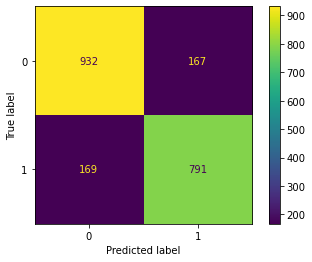

Classification Report : -
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1099
           1       0.83      0.82      0.82       960

    accuracy                           0.84      2059
   macro avg       0.84      0.84      0.84      2059
weighted avg       0.84      0.84      0.84      2059

LogisticRegression    


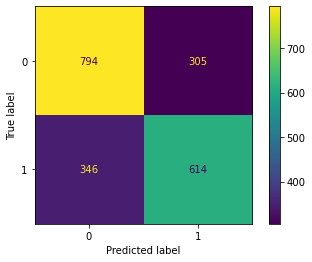

Classification Report : -
               precision    recall  f1-score   support

           0       0.70      0.72      0.71      1099
           1       0.67      0.64      0.65       960

    accuracy                           0.68      2059
   macro avg       0.68      0.68      0.68      2059
weighted avg       0.68      0.68      0.68      2059

RandomForestClassifier


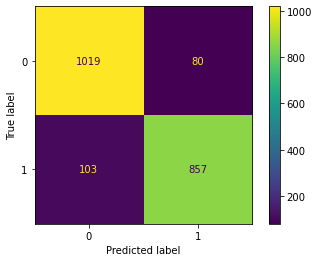

Classification Report : -
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      1099
           1       0.91      0.89      0.90       960

    accuracy                           0.91      2059
   macro avg       0.91      0.91      0.91      2059
weighted avg       0.91      0.91      0.91      2059

KNeighborsClassifier  


Classification Report : -
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      1099
           1       0.85      0.83      0.84       960

    accuracy                           0.85      2059
   macro avg       0.85      0.85      0.85      2059
weighted avg       0.85      0.85      0.85      2059

SVC                   


Classification Report : -
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1099
           1       0.96      0.95      0.95       960

    accuracy                           0.96      2059
   macro avg       0.96      0.96      0.96      2059
weighted avg       0.96      0.96      0.96      2059



In [36]:
list_smodels = ['DecisionTreeClassifier', 'LogisticRegression    ', 'RandomForestClassifier', 'KNeighborsClassifier  ',
                'SVC                   ']
list_models = [DecisionTreeClassifier, LogisticRegression,  RandomForestClassifier,  KNeighborsClassifier, SVC]
list_scores = ["Av. F1_train", "Accuracy", "Recall", "Precision", "F1_test"] # ,"ROC AUC Score"
pd_list = []
sc = MinMaxScaler
#sc = StandardScaler
#sc = RobustScaler #(quantile_range=(25, 75)).fit_transform(X)

for (m, ms) in zip(list_models, list_smodels):
    
    if m != KNeighborsClassifier:
        model = m(random_state=42)
    else: model = m()
    pipe = Pipeline(steps = [('scale', sc()),('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    pd_list.append(pd.DataFrame(data=[
                               cross_val_score(pipe,X_train ,y_train ,cv=6, scoring='f1', n_jobs=2).mean(),
                               accuracy_score(y_test, y_pred),
                               recall_score(y_test, y_pred),
                               precision_score(y_test, y_pred),
                               f1_score(y_test,y_pred)], 
                               #,roc_auc_score(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))
    print(ms)
    cm =confusion_matrix(y_test, y_pred, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    namemat = ms + '.png'
    plt.savefig(namemat)
    plt.show()
    print(f"Classification Report : -\n {classification_report(y_test, y_pred)}")  
#     cross = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
#     print(cross.to_markdown())

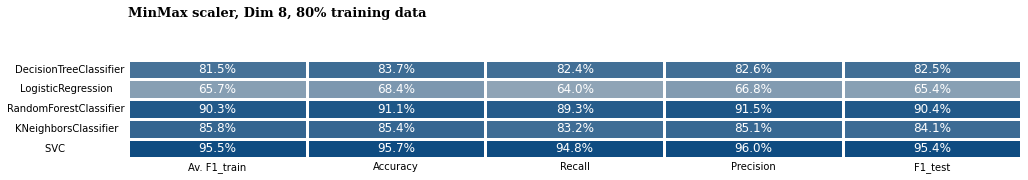

In [42]:
df_models = round(pd.concat(pd_list, axis=1),3)

colors = ["lightgray","lightgray","#0f4c81"]
colormap = clrs.LinearSegmentedColormap.from_list("", colors)


fig = plt.figure(figsize=(16, 10)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
#fig.patch.set_facecolor(background_color) # figure background color
#ax0.set_facecolor(background_color) 
ax0.text(0,-2.15,'MinMax scaler, Dim 8, 80% training data',fontsize=13,fontweight='bold',fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)
plt.savefig('scores_08train_multval_minmaxsc.png')

# All-around models with default values and  RobustScaler

DecisionTreeClassifier


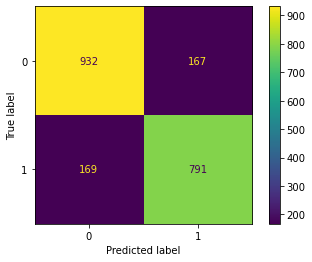

Classification Report : -
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1099
           1       0.83      0.82      0.82       960

    accuracy                           0.84      2059
   macro avg       0.84      0.84      0.84      2059
weighted avg       0.84      0.84      0.84      2059

LogisticRegression    


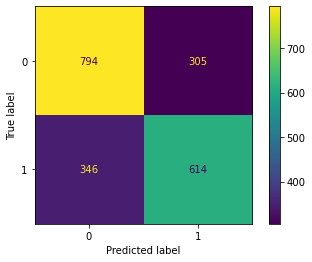

Classification Report : -
               precision    recall  f1-score   support

           0       0.70      0.72      0.71      1099
           1       0.67      0.64      0.65       960

    accuracy                           0.68      2059
   macro avg       0.68      0.68      0.68      2059
weighted avg       0.68      0.68      0.68      2059

RandomForestClassifier


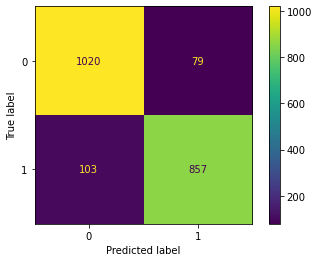

Classification Report : -
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      1099
           1       0.92      0.89      0.90       960

    accuracy                           0.91      2059
   macro avg       0.91      0.91      0.91      2059
weighted avg       0.91      0.91      0.91      2059

KNeighborsClassifier  


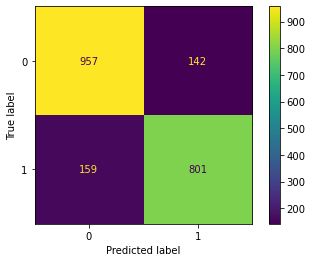

Classification Report : -
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      1099
           1       0.85      0.83      0.84       960

    accuracy                           0.85      2059
   macro avg       0.85      0.85      0.85      2059
weighted avg       0.85      0.85      0.85      2059

SVC                   


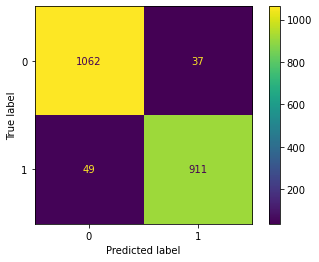

Classification Report : -
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1099
           1       0.96      0.95      0.95       960

    accuracy                           0.96      2059
   macro avg       0.96      0.96      0.96      2059
weighted avg       0.96      0.96      0.96      2059



In [45]:
pd_list = []
#sc = MinMaxScaler
#sc = StandardScaler
sc = RobustScaler #(quantile_range=(25, 75)).fit_transform(X)

for (m, ms) in zip(list_models, list_smodels):
    
    if m != KNeighborsClassifier:
        model = m(random_state=42)
    else: model = m()
    pipe = Pipeline(steps = [('scale', sc()),('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    pd_list.append(pd.DataFrame(data=[
                               cross_val_score(pipe,X_train ,y_train ,cv=6, scoring='f1', n_jobs=2).mean(),
                               accuracy_score(y_test, y_pred),
                               recall_score(y_test, y_pred),
                               precision_score(y_test, y_pred),
                               f1_score(y_test,y_pred)], 
                               #,roc_auc_score(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))
    print(ms)
    cm =confusion_matrix(y_test, y_pred, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    namemat = ms + '.png'
    plt.savefig(namemat)
    plt.show()
    print(f"Classification Report : -\n {classification_report(y_test, y_pred)}")  

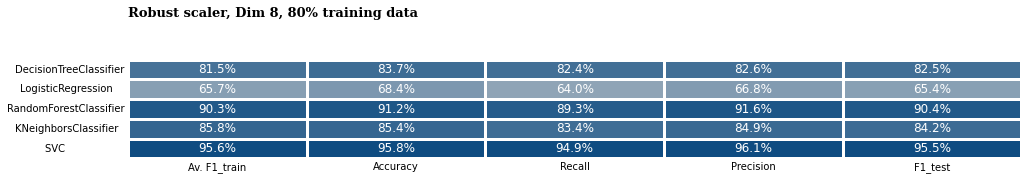

In [46]:
df_models = round(pd.concat(pd_list, axis=1),3)

colors = ["lightgray","lightgray","#0f4c81"]
colormap = clrs.LinearSegmentedColormap.from_list("", colors)


fig = plt.figure(figsize=(16, 10)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
ax0.text(0,-2.15,'Robust scaler, Dim 8, 80% training data',fontsize=13,fontweight='bold',fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)
plt.savefig('scores_08train_multval_robustsc.png')

# All-around models with default values and  RobustScaler

DecisionTreeClassifier


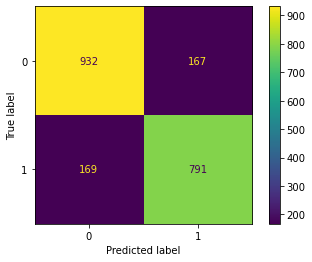

Classification Report : -
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1099
           1       0.83      0.82      0.82       960

    accuracy                           0.84      2059
   macro avg       0.84      0.84      0.84      2059
weighted avg       0.84      0.84      0.84      2059

LogisticRegression    


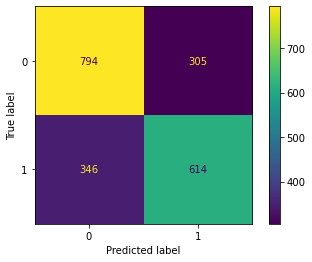

Classification Report : -
               precision    recall  f1-score   support

           0       0.70      0.72      0.71      1099
           1       0.67      0.64      0.65       960

    accuracy                           0.68      2059
   macro avg       0.68      0.68      0.68      2059
weighted avg       0.68      0.68      0.68      2059

RandomForestClassifier


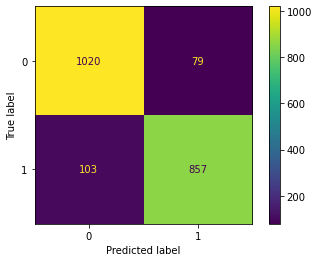

Classification Report : -
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      1099
           1       0.92      0.89      0.90       960

    accuracy                           0.91      2059
   macro avg       0.91      0.91      0.91      2059
weighted avg       0.91      0.91      0.91      2059

KNeighborsClassifier  


Classification Report : -
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      1099
           1       0.85      0.83      0.84       960

    accuracy                           0.85      2059
   macro avg       0.85      0.85      0.85      2059
weighted avg       0.85      0.85      0.85      2059

SVC                   


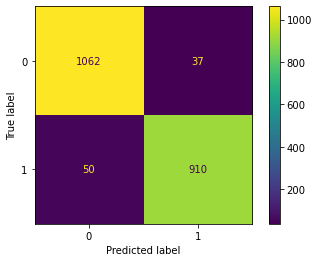

Classification Report : -
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1099
           1       0.96      0.95      0.95       960

    accuracy                           0.96      2059
   macro avg       0.96      0.96      0.96      2059
weighted avg       0.96      0.96      0.96      2059



In [54]:
pd_list = []
#sc = MinMaxScaler
sc = StandardScaler
#sc = RobustScaler #(quantile_range=(25, 75)).fit_transform(X)

for (m, ms) in zip(list_models, list_smodels):
    
    if m != KNeighborsClassifier:
        model = m(random_state=42)
    else: model = m()
    pipe = Pipeline(steps = [('scale', sc()),('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    pd_list.append(pd.DataFrame(data=[
                               cross_val_score(pipe,X_train ,y_train ,cv=6, scoring='f1', n_jobs=2).mean(),
                               accuracy_score(y_test, y_pred),
                               recall_score(y_test, y_pred),
                               precision_score(y_test, y_pred),
                               f1_score(y_test,y_pred)], 
                               #,roc_auc_score(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))
    print(ms)
    cm =confusion_matrix(y_test, y_pred, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    namemat = ms + '.png'
    plt.savefig(namemat)
    plt.show()
    print(f"Classification Report : -\n {classification_report(y_test, y_pred)}")  

In [48]:
df_models = round(pd.concat(pd_list, axis=1),3)

colors = ["lightgray","lightgray","#0f4c81"]
colormap = clrs.LinearSegmentedColormap.from_list("", colors)


fig = plt.figure(figsize=(16, 10)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
ax0.text(0,-2.15,'Standard scaler, Dim 8, 80% training data',fontsize=13,fontweight='bold',fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)
plt.savefig('scores_08train_multval_standardsc.png')

# Grid search
A grid search did not improve the F1-score, indeed it worsen it in most cases.

## Grid Search. Supportive vector machines

In [121]:
param_grid = {'kernel':('linear', 'rbf', 'sigmoid'), 'C': [1, 2, 5, 10], 'random_state': [42]}
svc = SVC()

grid = GridSearchCV(svc, param_grid, scoring='f1', cv=6)
svc_pipe_gs = Pipeline(steps=[('scale', sc()), ('GS', grid)])
svc_pipe_gs.fit(X_train, y_train)
print('best tuned par:', grid.best_params_)

best tuned par: {'C': 2, 'kernel': 'rbf', 'random_state': 42}


In [105]:
# best tuned par: {'C': 1, 'kernel': 'rbf', 'random_state': 42}
#logreg_pipe_gs = Pipeline(steps=[('scale', sc()), ('GS', grid)])

pd_list_gs = []   
svc_pipe = Pipeline(steps = [ ('SVC', SVC(C=2, kernel='rbf',
                                                                    random_state=42))])
svc_pipe.fit(X_train,y_train)
y_pred_gs = svc_pipe.predict(X_test)
#y_pred_gs = logreg_pipe.predict(X_test)
ms = "SVC"
pd_list_gs.append(pd.DataFrame(data=[
                               cross_val_score(svc_pipe,X_train ,y_train ,cv=6, n_jobs=2).mean(),
                               accuracy_score(y_test, y_pred_gs),
                               recall_score(y_test, y_pred_gs),
                               precision_score(y_test, y_pred_gs),
                               f1_score(y_test,y_pred_gs)], 
                               #,roc_auc_score(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))
confusion_matrix(y_test, y_pred)
cross = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(cross.to_markdown())

| Actual   |    0 |   1 |   All |
|:---------|-----:|----:|------:|
| 0        | 1062 |  37 |  1099 |
| 1        |   50 | 910 |   960 |
| All      | 1112 | 947 |  2059 |


## Grid Search. Random Forest Classifier

In [55]:
n_estimators =[64, 100, 128, 200]
max_features = [2, 3, 5, 7]
bootstrap = [True, False]
random_state = [42]
param_grid = {'n_estimators': n_estimators, 'max_features': max_features,
              'bootstrap': bootstrap, 'random_state': random_state}
rfc = RandomForestClassifier()
grid = GridSearchCV(rfc, param_grid)
grid.fit(X_train,y_train)
print('best tuned par:', grid.best_params_)

best tuned par: {'bootstrap': True, 'max_features': 2, 'n_estimators': 200, 'random_state': 42}


In [106]:
# best tuned par: {'bootstrap': False, 'max_features': 2, 'n_estimators': 200, 'random_state': 42}

rfc_pipe = Pipeline(steps = [('scale', sc()), ('RFC',RandomForestClassifier(max_features=2,
                             n_estimators=200, bootstrap=False, random_state=42, n_jobs=4))])

rfc_pipe.fit(X_train, y_train)
y_pred_gs = rfc_pipe.predict(X_test)
ms = "RandomForestClassifier"
pd_list_gs.append(pd.DataFrame(data=[
                               cross_val_score(rfc_pipe,X_train ,y_train ,cv=6, n_jobs=2).mean(),
                               accuracy_score(y_test, y_pred_gs),
                               recall_score(y_test, y_pred_gs),
                               precision_score(y_test, y_pred_gs),
                               f1_score(y_test,y_pred_gs)], 
                               #,roc_auc_score(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))

confusion_matrix(y_test, y_pred)
cross = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(cross.to_markdown())

| Actual   |    0 |   1 |   All |
|:---------|-----:|----:|------:|
| 0        | 1062 |  37 |  1099 |
| 1        |   50 | 910 |   960 |
| All      | 1112 | 947 |  2059 |


## Grid Search.KNeighbors Klassifier

In [69]:
n_neighbors = [3,5,7,9,11]
weights = ('uniform', 'distance')
leaf_size = [5, 10, 15, 20,25,30,35]
p=[1,2]
random_state = [42]
n_jobs = [4]

param_grid = {'n_neighbors': n_neighbors, 'weights': weights,
              'leaf_size': leaf_size, 'p':p, 'n_jobs':n_jobs}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid)
grid.fit(X_train,y_train)
print('best tuned par:', grid.best_params_)

best tuned par: {'leaf_size': 5, 'n_jobs': 4, 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}


In [122]:
# best tuned par: {'leaf_size': 5, 'n_jobs': 4, 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}

knn_pipe = Pipeline(steps = [('scale', sc()), ('KNNC',KNeighborsClassifier(leaf_size=5,
                             n_neighbors=11, weights='uniform', n_jobs=4))])

knn_pipe.fit(X_train, y_train)
y_pred_gs = rfc_pipe.predict(X_test)
ms = "KNNC"
pd_list_gs.append(pd.DataFrame(data=[
                               cross_val_score(knn_pipe,X_train ,y_train ,cv=6, n_jobs=2).mean(),
                               accuracy_score(y_test, y_pred_gs),
                               recall_score(y_test, y_pred_gs),
                               precision_score(y_test, y_pred_gs),
                               f1_score(y_test,y_pred_gs)], 
                               #,roc_auc_score(y_test, y_pred)], 
                       columns=[ms],
                       index=list_scores))

confusion_matrix(y_test, y_pred)
cross = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(cross.to_markdown())

| Actual   |    0 |   1 |   All |
|:---------|-----:|----:|------:|
| 0        | 1062 |  37 |  1099 |
| 1        |   50 | 910 |   960 |
| All      | 1112 | 947 |  2059 |


In [109]:
pd_list_gs

[                   SVC
 Av. F1_train  0.691730
 Accuracy      0.672171
 Recall        0.677083
 Precision     0.640394
 F1_test       0.658228,
               RandomForestClassifier
 Av. F1_train                0.909754
 Accuracy                    0.914036
 Recall                      0.904167
 Precision                   0.910808
 F1_test                     0.907475,
                   KNNC
 Av. F1_train  0.888740
 Accuracy      0.914036
 Recall        0.904167
 Precision     0.910808
 F1_test       0.907475]

# Importance features with reduced dimensionality

In this section, we employ a feature importance analysis. Here the idea is to identify dominating features that could play an important role in rightly identifying strokes. This will be seen in our plots by the height of each feature. Then based on the heights of the features we discriminate which feature may not be relevant and ignore them for the next round of machine learning prediction.

Here we use the method implemented in attribute the "feature_importances_" of "scikit-learn". The method starts by generating data sets with three features. We will apply this attribute to a Radom forest and a decision tree ML model to follow the purity of the features as the tree grows. The purity of the feature is plotted in the next plot bars.

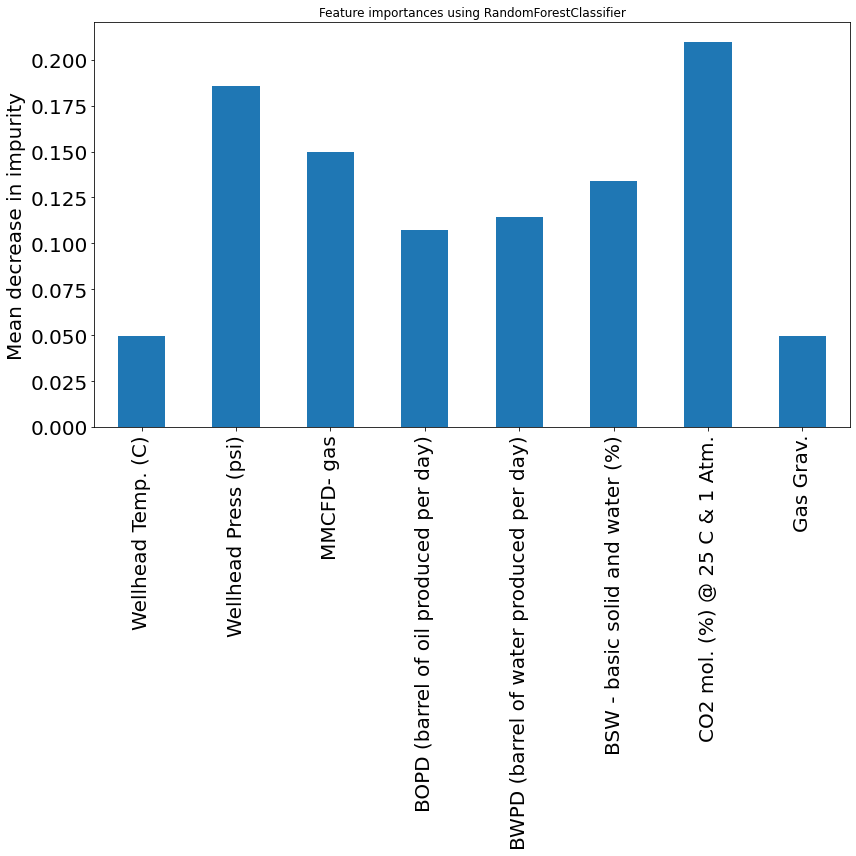

In [149]:
feature_names = ['Wellhead Temp. (C)', 'Wellhead Press (psi)', 'MMCFD- gas',
       'BOPD (barrel of oil produced per day)',
       'BWPD (barrel of water produced per day)',
       'BSW - basic solid and water (%)', 'CO2 mol. (%) @ 25 C & 1 Atm.','Gas Grav.']

# Normalization to features
X_train = MinMaxScaler().fit_transform(X_train)


model_cl = RandomForestClassifier(random_state=42) #SVC()
model_cl.fit(X_train, y_train)
importances = model_cl.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots(figsize=(12,12))
forest_importances.plot.bar(ax=ax)  # , yerr=std
title = "Feature importances using RandomForestClassifier"
ax.set_title(title)
ax.set_ylabel("Mean decrease in impurity", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
fig.tight_layout()
#svp = 'importfeat' + m + '.png'
#     plt.savefig(svp)
plt.show()

# Neural Networks with TensorFlow
As last strategy to achive higher recall score, we design with the help of TensorFlow a neural network. Here the strategy we follow was to set an early stop for the epochs while we were monitoring the the recall score in a double inner neural network with 100 and 50 neurons, respectevely.

In [5]:
from tensorflow import keras
import tensorflow_addons as tfa

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
print(X_train.shape,X_test.shape)
# Normalization to features
X_train = MinMaxScaler().fit_transform(X_train)

(7204, 8) (3088, 8)


In [38]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(4, activation='gelu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(4, activation='gelu'))
model.add(keras.layers.Dropout(0.2))
#model.add(keras.layers.Dense(10, activation='relu'))
# Output layer for binary classification
model.add(keras.layers.Dense(1, activation='sigmoid'))

rec = keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name='recall', dtype=None)
pre = keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name='precision', dtype=None)
f_1 = tfa.metrics.F1Score(num_classes=2)

model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy', rec, pre])

# Use callback to stop the trainning after recall does not improve after 10 epochs
#callback = keras.callbacks.EarlyStopping(monitor='recall',patience=44, mode="auto")

history = model.fit(X_train, y_train, batch_size=100,
                    epochs=500, verbose=False,
                    validation_data=(X_test, y_test),
#                    callbacks=[callback]
                    )

len(history.history['recall'])

print(history.history.keys())

plt.plot(figsize=(12,9))
plt.plot(history.history['accuracy'], label='train data')
plt.plot(history.history['val_accuracy'], label='test data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['recall'], label='train data')
plt.plot(history.history['val_recall'], label='test data')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.plot(history.history['precision'], label='train data')
plt.plot(history.history['val_precision'], label='test data')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

y_pred_test = model.predict(X_test, verbose=False)
print('Accuracy of test data:', accuracy_score(y_test, np.round(y_pred_test)))

y_pred_train = model.predict(X_train, verbose=False)
print('Accuracy of train data:', accuracy_score(
    y_train, np.round(y_pred_train)))

y_pred_test = model.predict(X_test, verbose=False)
print('Recall of test data:', recall_score(y_test, np.round(y_pred_test)))
print('Precision of test data:', precision_score(y_test, np.round(y_pred_test)))

y_pred_train = model.predict(X_train, verbose=False)
print('Recall of train data:', recall_score(y_train, np.round(y_pred_train)))
print('Precision of train data:', precision_score(y_train, np.round(y_pred_train)))
    
y_pred = np.round(model.predict(X_test))
cm =confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])


Accuracy of test data: 0.5362694300518135
Accuracy of train data: 0.8663242642976124
Recall of test data: 0.8050490883590463
Precision of test data: 0.49869678540399653
Recall of train data: 0.8181547619047619
Precision of train data: 0.8864882296033537
97/97 [==============================] - 0s 759us/step
